# Differential Peak Shape Analysis

**Created**: 27 April 2022

## Environment

In [1]:
import collections
import os

import numpy as np
import pandas as pd
import pyBigWig
import matplotlib.pyplot as plt
from matplotlib import gridspec

## Load Data

In [2]:
ds_peaks = pd.read_csv('/nfs/users/nfs_n/nm18/gains_team282/epigenetics/regulation/immune/ds_peaks.csv')

In [3]:
ds_peaks.head()

,Cell.Type,Peak.ID,Peak.Chr,Peak.Start,Peak.End,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,Monocytes,8:26382095-26384716,8,26382095,26384716,-0.211463,-0.001963,-8.465994,7.007800e-14,4.969091e-09,19.972236
1,Monocytes,12:57279816-57281063,12,57279816,57281063,0.190867,0.006330,7.768891,2.878854e-12,1.020669e-07,16.664753
2,Monocytes,12:39990020-39991169,12,39990020,39991169,-0.232986,0.001711,-6.476917,2.107963e-09,4.518278e-05,10.768454
3,Monocytes,X:40579957-40582072,X,40579957,40582072,-0.172663,-0.000925,-6.438248,2.548811e-09,4.518278e-05,10.598439
4,Monocytes,2:189142991-189143762,2,189142991,189143762,-0.227164,0.002668,-6.286680,5.338837e-09,7.571325e-05,9.936468


In [4]:
metadata = pd.read_csv('/nfs/users/nfs_n/nm18/eQTL_pQTL_Characterization/03_Functional_Interpretation/metadata/reads_atac_seq.txt')

In [5]:
metadata.head()

,Run,Group.ID,Sample.ID,Donor,Lineage,Cell_type,Stimulated,Treatment,Replicate,Assay.Type,...,Experiment,Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,Sample.Name,SRA.Study
0,SRR2920475,Corces-4983-Monocytes-Control,Corces-4983-Monocytes-Control-1,Corces-4983,MYELOID,Monocytes,False,Control,1,ATAC-Seq,...,SRX1427798,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937385,SRP066100
1,SRR2920488,Corces-6792-Monocytes-Control,Corces-6792-Monocytes-Control-1,Corces-6792,MYELOID,Monocytes,False,Control,1,ATAC-Seq,...,SRX1427811,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937398,SRP066100
2,SRR2920476,Corces-4983-Monocytes-Control,Corces-4983-Monocytes-Control-2,Corces-4983,MYELOID,Monocytes,False,Control,2,ATAC-Seq,...,SRX1427799,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937386,SRP066100
3,SRR2920487,Corces-6792-Monocytes-Control,Corces-6792-Monocytes-Control-2,Corces-6792,MYELOID,Monocytes,False,Control,2,ATAC-Seq,...,SRX1427810,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937397,SRP066100
4,SRR2920542,Corces-7256-Monocytes-Control,Corces-7256-Monocytes-Control-1,Corces-7256,MYELOID,Monocytes,False,Control,1,ATAC-Seq,...,SRX1427865,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937452,SRP066100


## Load Fiedler Vectors

The Pandas `read_csv` function is very slow with large CSV files. Since I know that the shape features are in a well-formed CSV file, I wrote my own function to quickly read the file with minimal checks.

In [6]:
def load_fiedler_vectors():

    consensus_file = '/nfs/users/nfs_n/nm18/gains_team282/epigenetics/regulation/immune/shape_features/consensus_coverage_pcs.csv'
    
    data = collections.defaultdict(list)
    
    with open(consensus_file, 'r') as f_in:
        
        header = f_in.readline().strip().split(',')
        
        line = f_in.readline().strip()
        
        while line:
            
            line_elements = line.split(',')
        
            for i in range(len(header)):
                data[header[i]].append(line_elements[i])
            
            line = f_in.readline().strip()
        
    df = pd.DataFrame(data)
    df = df.set_index('Sample')
    df = df.astype(float)
    
    return df

In [7]:
fiedler_vectors = load_fiedler_vectors()

In [8]:
fiedler_vectors.head()

,1:804821-805016,1:812642-812879,1:815224-815554,1:817057-817622,1:819712-820327,1:821473-823221,1:826611-827935,1:838089-838609,1:840615-840851,1:842737-843033,...,X:155850897-155851144,X:155862338-155862667,X:155876786-155876963,X:155877337-155877633,X:155880556-155882240,X:155888212-155888502,X:155898696-155899182,X:155899277-155899571,X:155956186-155956393,X:155966976-155967132
Sample,,,,,,,,,,,,,,,,,,,,,
Calderon-1001-Bulk_B-Control,0.017270,-0.047330,0.143835,-0.010878,0.020619,-0.093154,0.121238,0.020444,-0.032574,0.009885,...,0.120622,0.021268,-0.011215,0.001356,-0.090332,-0.167142,-0.012692,-0.135215,-0.021402,-0.020616
Calderon-1001-Bulk_B-Treatment_1,0.014899,-0.047330,-0.001664,0.095529,0.092631,-0.018727,-0.001299,-0.042388,-0.226866,0.017590,...,-0.011955,0.084515,0.013514,0.018036,-0.105898,-0.059812,0.062218,0.154952,-0.011493,-0.006091
Calderon-1001-CD8pos_T-Control,0.019515,-0.017123,0.137158,-0.039014,0.016425,0.021588,0.041197,0.000574,0.107922,-0.104399,...,-0.011955,-0.119983,-0.120120,-0.148539,-0.038597,-0.030073,0.125210,-0.114720,-0.041256,0.018517
Calderon-1001-CD8pos_T-Treatment_1,-0.122162,-0.052431,-0.001664,-0.059736,0.051223,-0.053381,0.038915,-0.083565,0.045520,-0.103853,...,-0.011955,-0.015140,0.020346,0.107127,-0.036152,0.083359,0.033481,-0.006418,0.023074,0.029311
Calderon-1001-Central_memory_CD8pos_T-Control,-0.089773,-0.047330,-0.001664,-0.025633,0.059982,-0.068731,0.033002,-0.044362,0.026855,0.093907,...,-0.105419,0.016070,-0.100110,-0.048700,-0.053028,0.050493,-0.153063,-0.138351,0.002861,0.012654


## Top Peaks in Monocytes

In [9]:
samples = metadata[metadata['Group.ID'].str.contains('Calderon') | metadata['Group.ID'].str.contains('Corces')]['Group.ID'].tolist()

In [66]:
cell_peaks = ds_peaks[ds_peaks['Cell.Type'] == 'Central_memory_CD8pos_T']

cell_peaks.iloc[
    np.argsort(cell_peaks['Peak.End'] - cell_peaks['Peak.Start']),
    :
].iloc[::-1, :]

,Cell.Type,Peak.ID,Peak.Chr,Peak.Start,Peak.End,logFC,AveExpr,t,P.Value,adj.P.Val,B
41546,Central_memory_CD8pos_T,6:157272891-157275891,6,157272891,157275891,-0.117568,0.000639,-4.744587,5.775380e-06,3.608111e-04,3.712740
42648,Central_memory_CD8pos_T,15:80693970-80696970,15,80693970,80696970,0.115348,0.002547,4.054003,8.943214e-05,2.834803e-03,1.161414
40432,Central_memory_CD8pos_T,21:33974907-33977907,21,33974907,33977907,-0.172112,-0.007389,-7.760910,3.002387e-12,1.006947e-08,17.406610
40522,Central_memory_CD8pos_T,6:7153682-7156682,6,7153682,7156682,0.176028,0.001065,6.787419,4.507466e-10,2.849354e-07,12.645785
42785,Central_memory_CD8pos_T,4:56906827-56909827,4,56906827,56909827,-0.102137,0.001523,-3.991373,1.130626e-04,3.377018e-03,0.944630
...,...,...,...,...,...,...,...,...,...,...,...
42796,Central_memory_CD8pos_T,12:6684448-6685081,12,6684448,6685081,-0.142621,0.001372,-3.987157,1.148510e-04,3.413190e-03,0.930130
43166,Central_memory_CD8pos_T,22:43033707-43034338,22,43033707,43034338,0.141159,0.005575,3.827056,2.067164e-04,5.319975e-03,0.388167
42740,Central_memory_CD8pos_T,2:201858694-201859324,2,201858694,201859324,0.174186,0.001920,4.008298,1.061467e-04,3.230637e-03,1.002962
42345,Central_memory_CD8pos_T,5:148456998-148457607,5,148456998,148457607,-0.162918,-0.000075,-4.212260,4.892473e-05,1.793062e-03,1.720425


In [79]:
peak_idx = 40432
chrom = ds_peaks.loc[peak_idx, 'Peak.Chr']
start = ds_peaks.loc[peak_idx, 'Peak.Start']
end = ds_peaks.loc[peak_idx, 'Peak.End']

In [80]:
sample_dir = '/nfs/users/nfs_n/nm18/gains_team282/epigenetics/accessibility/merged/atac_seq/'

region = list()

for sample in samples:
    
    bw_file = pyBigWig.open(os.path.join(sample_dir, sample, 'alignment', f'{sample}.bw'))

    values = np.array(bw_file.values(chrom, start, end))

    values[np.isnan(values)] = 0

    if values.sum() > 0:
        values = values / values.sum()
    else:
        values = np.array([1 / (end - start)] * (end - start))

    region.append(values)
    
distribution = np.vstack(region)

In [81]:
peak_id = f'{chrom}:{start}-{end}'
fiedler_vector = fiedler_vectors.loc[samples, peak_id].to_numpy()

In [82]:
peak_id

'21:33974907-33977907'

In [83]:
cors = [np.corrcoef(fiedler_vector, distribution[:, i])[0, 1] for i in range(distribution.shape[1])]
cors = np.expand_dims(np.array(cors), axis=0)
cors = np.vstack([np.abs(cors)] * 100)

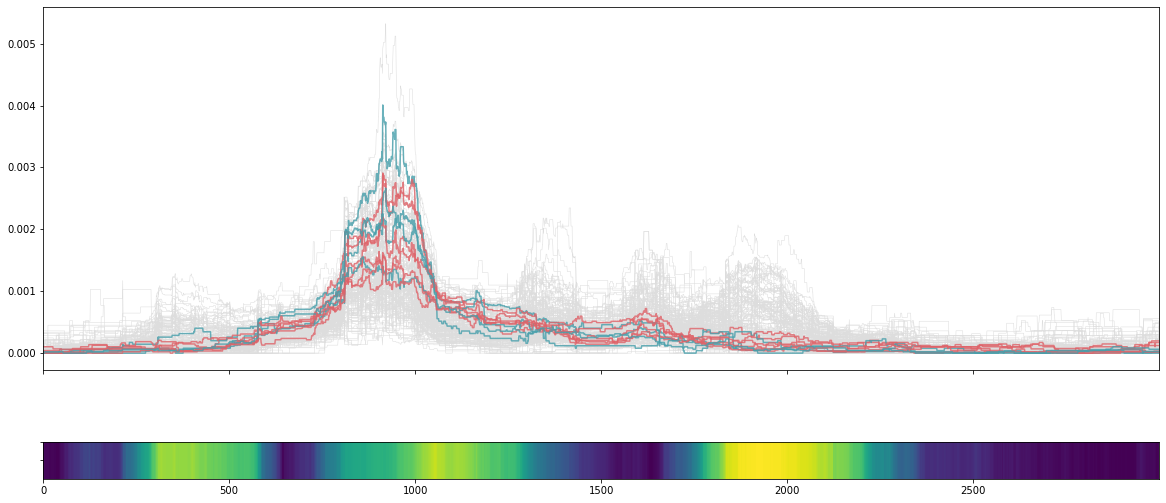

In [84]:
plt.rcParams["figure.figsize"] = (20, 10)

fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# Top subplot
ax0 = plt.subplot(gs[0])

for i in range(distribution.shape[0]):
    if metadata.loc[i, 'Cell_type'] != 'Mature_NK':
        ax0.plot(list(range(distribution.shape[1])), distribution[i, :], color="#DDDDDD", linewidth=0.5)

for i in range(distribution.shape[0]):
    if metadata.loc[i, 'Cell_type'] == 'Mature_NK':
        if metadata.loc[i, 'Stimulated']:
            ax0.plot(list(range(distribution.shape[1])), distribution[i, :], color="#DF6369", alpha=0.8)
        else:
            ax0.plot(list(range(distribution.shape[1])), distribution[i, :], color="#469FAB", alpha=0.8)

# Bottom subplot
ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.imshow(cors)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), visible=False)

plt.subplots_adjust(hspace=0)
plt.show()